<a href="https://colab.research.google.com/github/goldspruce/EEG_stats/blob/main/Hsu_EEG_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

italicized text# Import package
source: https://mne.tools/stable/auto_tutorials/stats-sensor-space/20_erp_stats.html

background: https://mne.tools/stable/auto_tutorials/stats-sensor-space/10_background_stats.html

In [1]:
!pip install mne
import mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.0 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind

from mne.channels import find_ch_adjacency, make_1020_channel_selections
from mne.stats import spatio_temporal_cluster_test

# **Tranditional Statistical Analysis**

In [3]:
np.random.seed(0)

# Load the data
path = mne.datasets.kiloword.data_path() / "kword_metadata-epo.fif"
epochs = mne.read_epochs(path)
# These data are quite smooth, so to speed up processing we'll (unsafely!) just
# decimate them
epochs.decimate(4, verbose="error")
name = "NumberOfLetters"

# Split up the data by the median length in letters via the attached metadata
median_value = str(epochs.metadata[name].median())
long_words = epochs[name + " > " + median_value]
short_words = epochs[name + " < " + median_value]

Using default location ~/mne_data for kiloword...
Creating /root/mne_data


100%|█████████████████████████████████████| 25.5M/25.5M [00:00<00:00, 2.33GB/s]
Untarring contents of '/root/mne_data/MNE-kiloword-data.tar.gz' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Download complete in 08s (24.3 MB)
Reading /root/mne_data/MNE-kiloword-data/kword_metadata-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -100.00 ...     920.00 ms
        0 CTF compensation matrices available
Adding metadata with 8 columns
960 matching events found
No baseline correction applied
0 projection items activated


In [4]:
print(median_value, long_words, short_words)

6.0 <EpochsFIF | 384 events (all good), -0.096 – 0.912 s (baseline off), ~5.5 MiB, data loaded, with metadata,
 'spectra': 1
 'judgment': 1
 'scuffle': 1
 'abstract': 1
 'struggle': 1
 'attitude': 1
 'japanese': 1
 'district': 1
 'display': 1
 'purpose': 1
 and 374 more events ...> <EpochsFIF | 384 events (all good), -0.096 – 0.912 s (baseline off), ~5.5 MiB, data loaded, with metadata,
 'loft': 1
 'fire': 1
 'uncle': 1
 'virus': 1
 'save': 1
 'orgy': 1
 'papa': 1
 'sign': 1
 'bench': 1
 'door': 1
 and 374 more events ...>


Using matplotlib as 2D backend.


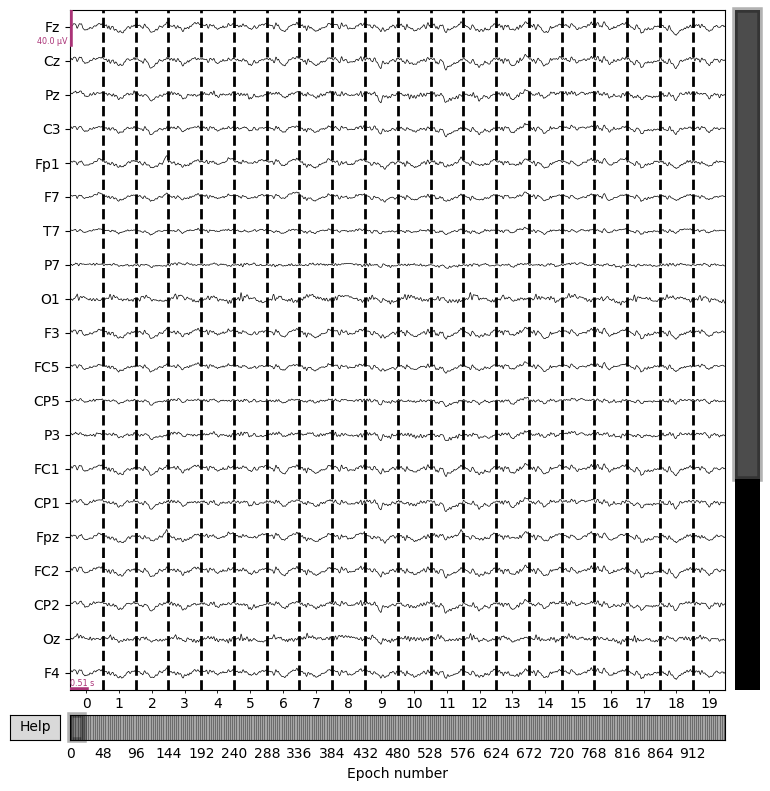

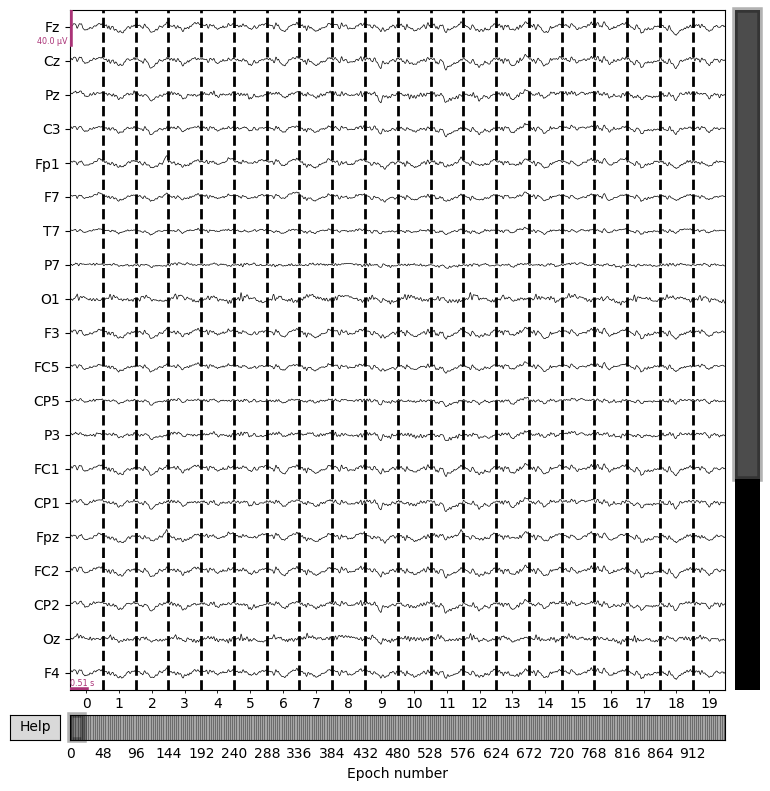

In [5]:
epochs.plot()

# create evoked to visualize how the data looks like

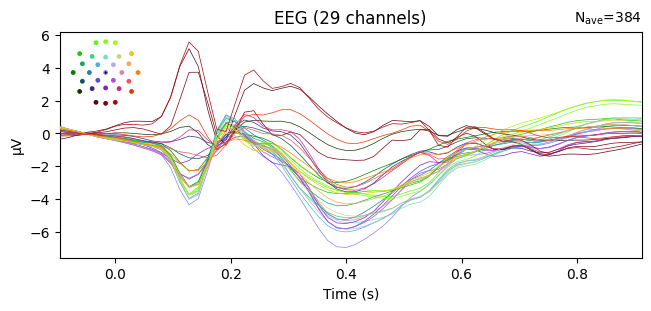

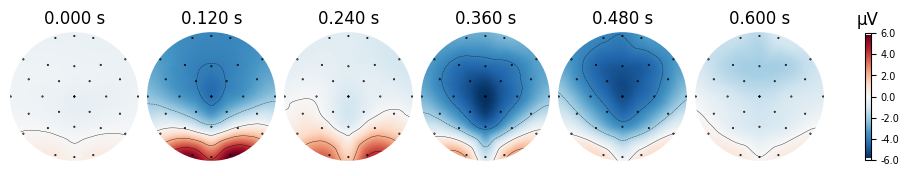

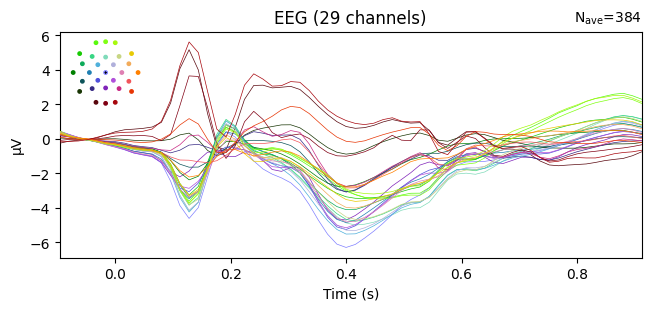

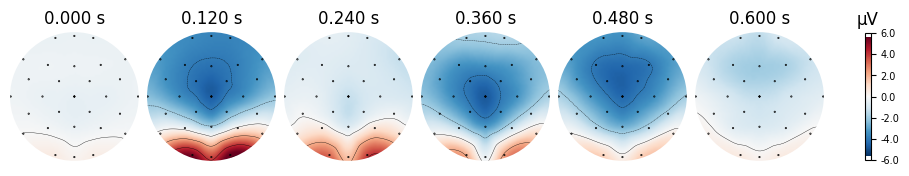

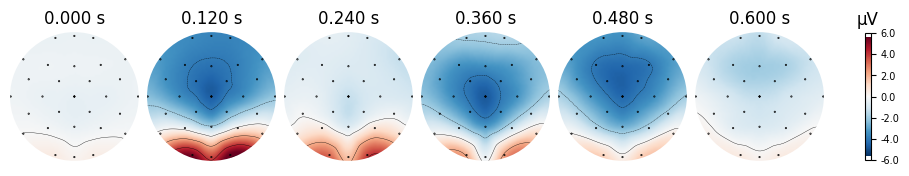

In [6]:
evoked_long= long_words.average()
evoked_short = short_words.average()

import numpy as np
evoked_short.plot(time_unit='s')
evoked_short.plot_topomap(times=np.linspace(0, 0.6, 6),ch_type='eeg',time_unit='s')

evoked_long.plot(time_unit='s')
evoked_long.plot_topomap(times=np.linspace(0, 0.6, 6),ch_type='eeg',time_unit='s')

# Convert the data into Pandas Dataframe format
What is Pandas? https://pandas.pydata.org/docs/getting_started/intro_tutorials/index.html

In [7]:
time_windows = [0.35, 0.45]
elecs = ["Fz", "Cz", "Pz"]
index = ["condition", "epoch", "time"]

# display the EEG data in Pandas format (first 5 rows)
print(epochs.to_data_frame(index=index)[elecs].head())
tmin = time_windows[0]
tmax = time_windows[1]
report = "{elec}, time:{tmin}-{tmax}s; t({df})={t_val:.3f}, p={p:.3f}"  ## for print(report.format(**format_dict))

print("\nTargeted statistical test results:")

long_df = long_words.copy().crop(time_windows[0],time_windows[1]).to_data_frame(index=index)
short_df = short_words.copy().crop(time_windows[0],time_windows[1]).to_data_frame(index=index)

grand_dict=[] ## for grand_dict.append(format_dict)

for elec in elecs:
  # extract data
  A = long_df[elec].groupby("condition").mean()
  B = short_df[elec].groupby("condition").mean()

  # conduct t test
  t, p = ttest_ind(A, B)

  # display results
  format_dict = dict(elec=elec, tmin=tmin, tmax=tmax, df=len(epochs.events) - 2, t_val=t, p=p)
  print(report.format(**format_dict))

  #
  grand_dict.append(format_dict)

channel                       Fz        Cz        Pz
condition epoch time                                
film      0     -0.096  0.453939  0.232879  0.222424
                -0.080  0.518939  0.214091 -0.371515
                -0.064  0.811667  0.793636  0.250152
                -0.048  0.039697  0.188636  0.318030
                -0.032 -1.163030 -1.018939 -0.425152

Targeted statistical test results:
Fz, time:0.35-0.45s; t(958)=5.304, p=0.000
Cz, time:0.35-0.45s; t(958)=5.684, p=0.000
Pz, time:0.35-0.45s; t(958)=6.508, p=0.000


In [8]:
print(long_df)

channel                      Fz        Cz         Pz        C3       Fp1  \
condition epoch time                                                       
purpose   144   0.352 -5.787500 -5.697031  -2.142187 -4.341250 -4.741250   
                0.368 -6.459688 -6.817500  -3.804219 -5.016719 -4.494219   
                0.384 -6.613281 -7.361094  -5.725781 -4.964375 -4.856875   
                0.400 -6.590937 -7.059375  -6.003750 -4.773906 -5.258438   
                0.416 -7.275938 -7.190938  -5.052969 -5.163594 -5.681875   
...                         ...       ...        ...       ...       ...   
solenoid  959   0.384 -4.791905 -8.940000 -11.582381 -8.140635 -3.144286   
                0.400 -4.333333 -8.521587 -10.941111 -7.757778 -2.456984   
                0.416 -4.900952 -8.785873 -10.663333 -7.972698 -2.589683   
                0.432 -5.496349 -9.258889 -10.577937 -8.900317 -3.774444   
                0.448 -5.875714 -9.677778 -10.688413 -9.098095 -4.592222   

channel    

In [9]:
print(grand_dict)
import pandas as pd
df = pd.DataFrame(grand_dict, columns=['elec','tmin','tmax','df','t_val','p'])
print(df)

[{'elec': 'Fz', 'tmin': 0.35, 'tmax': 0.45, 'df': 958, 't_val': np.float64(5.303744013944096), 'p': np.float64(1.4859887581603076e-07)}, {'elec': 'Cz', 'tmin': 0.35, 'tmax': 0.45, 'df': 958, 't_val': np.float64(5.683549057166432), 'p': np.float64(1.875269290140401e-08)}, {'elec': 'Pz', 'tmin': 0.35, 'tmax': 0.45, 'df': 958, 't_val': np.float64(6.5083773075781854), 'p': np.float64(1.372502400654676e-10)}]
  elec  tmin  tmax   df     t_val             p
0   Fz  0.35  0.45  958  5.303744  1.485989e-07
1   Cz  0.35  0.45  958  5.683549  1.875269e-08
2   Pz  0.35  0.45  958  6.508377  1.372502e-10


# **Non-parameteric statistical analysis**

In [10]:
# Calculate adjacency matrix between sensors from their locations
adjacency, _ = find_ch_adjacency(epochs.info, "eeg")

# Extract data: transpose because the cluster test requires channels to be last
# In this case, inference is done over items. In the same manner, we could
# also conduct the test over, e.g., subjects.
X = [long_words.get_data(copy=False).transpose(0, 2, 1),
  short_words.get_data(copy=False).transpose(0, 2, 1)]

## stardard parameters: threshold_tfce = dict(start=0, step=0.2)
tfce = dict(start=0.4, step=0.4)  # to speed up processing time for the demonstration

# Calculate statistical thresholds
t_obs, clusters, cluster_pv, h0 = spatio_temporal_cluster_test(
    X, tfce, adjacency=adjacency, n_permutations=100
)  # a more standard number would be 1000+
significant_points = cluster_pv.reshape(t_obs.shape).T < 0.05
print(str(significant_points.sum()) + " points selected by TFCE ...")

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 29
stat_fun(H1): min=7.176438127884552e-07 max=80.91729757691468
Running initial clustering …
Using 202 thresholds from 0.40 to 80.80 for TFCE computation (h_power=2.00, e_power=0.50)
Found 1856 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

362 points selected by TFCE ...


In [11]:
print(t_obs)
t_obs.shape

[[ 1.80481758  0.          1.16481758 ...  0.          0.
   0.        ]
 [ 0.          0.          1.16481758 ...  2.54142905  0.
   0.        ]
 [ 3.1254741   0.          0.         ...  0.          0.
   0.        ]
 ...
 [23.16301129 23.61555963 23.61555963 ... 12.55794494  0.
   0.        ]
 [17.95346707 20.84794827 22.42979918 ... 10.93412229  0.
   5.18864529]
 [ 7.27479006 14.02436916 19.03863987 ...  2.87555212  0.
   5.18864529]]


(64, 29)

No projector specified for this dataset. Please consider the method self.add_proj.


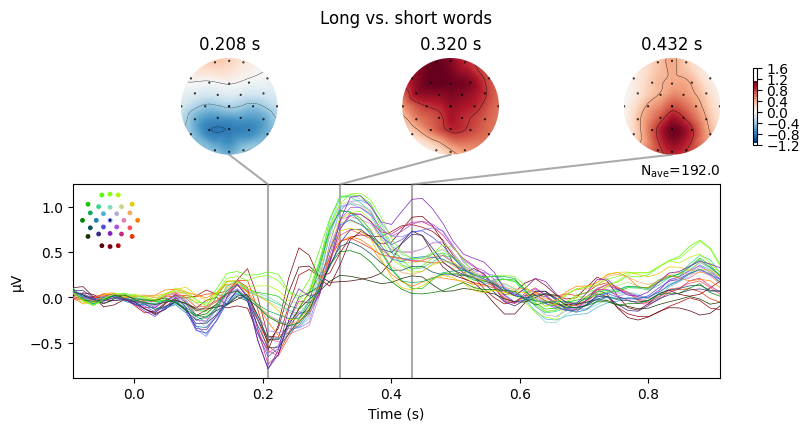

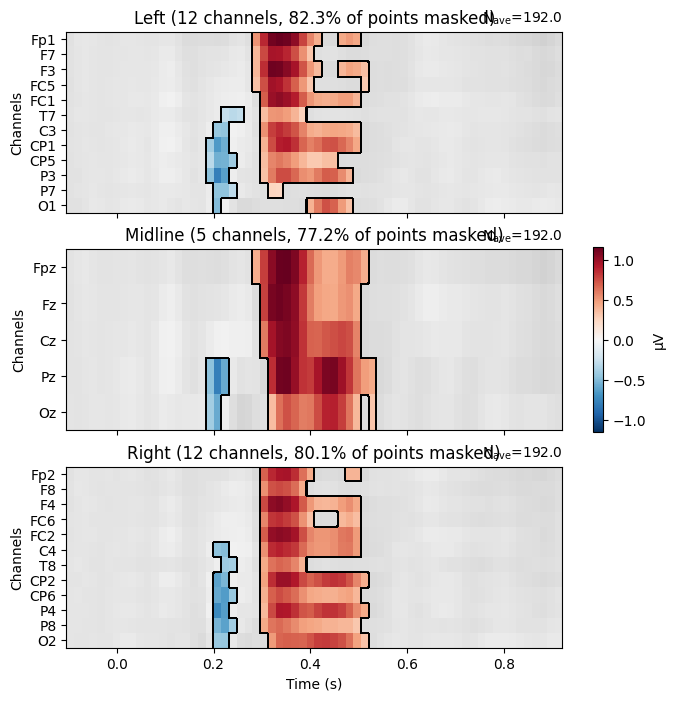

In [12]:
# We need an evoked object to plot the image to be masked
evoked = mne.combine_evoked(
    [long_words.average(), short_words.average()], weights=[1, -1])  # calculate difference wave
time_unit = dict(time_unit="s")
evoked.plot_joint(
    title="Long vs. short words", ts_args=time_unit, topomap_args=time_unit)  # show difference wave

# Create ROIs by checking channel labels
selections = make_1020_channel_selections(evoked.info, midline="z")
# https://mne.tools/stable/generated/mne.channels.make_1020_channel_selections.html

# Visualize the results
fig, axes = plt.subplots(nrows=3, figsize=(8, 8))
axes = {sel: ax for sel, ax in zip(selections, axes.ravel())}
evoked.plot_image(
    axes=axes,
    group_by=selections,
    colorbar=False,
    show=False,
    mask=significant_points,
    show_names="all",
    titles=None,
    **time_unit)
plt.colorbar(axes["Left"].images[-1], ax=list(axes.values()), shrink=0.3, label="µV")

plt.show()